In [ ]:
import os
import cv2
import torch
import pandas as pd
import numpy as np
import albumentations as A
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import CLIPProcessor, CLIPModel, BertModel, BertTokenizer, get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score, f1_score, classification_report
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/memo_3/memotion3/memotion3/train.csv')

In [ ]:
train_df.head(2)

,Unnamed: 0,image_url,humour,sarcastic,offensive,motivational,overall,ocr
0,0,https://encrypted-tbn0.gstatic.com/images?q=tb...,very_funny,twisted_meaning,not_offensive,not_motivational,neutral,Relationship status.\nSingle\nMarried\nIt's co...
1,1,https://encrypted-tbn0.gstatic.com/images?q=tb...,very_funny,twisted_meaning,slight,not_motivational,neutral,Bernie or REAGAN?\nBe informed. Compare them o...


In [ ]:
train_df['overall'] = train_df['overall'].replace({
                                                            'very_positive': 2,
                                                            'positive': 2,
                                                            'neutral': 1,
                                                            'very_negative': 0,
                                                            'negative': 0})

/tmp/ipython-input-3740866416.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_df['overall'] = train_df['overall'].replace({


In [ ]:
print(train_df['overall'].value_counts())

overall
1    2970
2    2275
0    1755
Name: count, dtype: int64


In [ ]:
val_df = pd.read_csv('/content/drive/MyDrive/memo_3/val.csv')

In [ ]:
val_df.head(2)

,Unnamed: 0,image_url,humour,sarcastic,offensive,motivational,overall,ocr
0,0,https://encrypted-tbn0.gstatic.com/images?q=tb...,funny,twisted_meaning,not_offensive,not_motivational,neutral,RVCJ\nwww.EVCI.COM\nTum paas aaye yun muskuray...
1,1,https://encrypted-tbn0.gstatic.com/images?q=tb...,very_funny,general,slight,not_motivational,negative,"rukjao Maqbeol,\nbabuji ko tum nalt muaracay-\..."


In [ ]:
val_df['overall'] = val_df['overall'].replace({
                                                            'very_positive': 2,
                                                            'positive': 2,
                                                            'neutral': 1,
                                                            'very_negative': 0,
                                                            'negative': 0})

/tmp/ipython-input-2159871312.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  val_df['overall'] = val_df['overall'].replace({


In [ ]:
print(val_df['overall'].value_counts())

overall
0    580
1    579
2    340
Name: count, dtype: int64


In [ ]:
# !pip install text_hammer

In [ ]:
import text_hammer as th

In [ ]:
%%time

from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()

def text_preprocessing(df, col_name):
  column = col_name
  df[column] = df[column].progress_apply(lambda x:str(x).lower())
  df[column] = df[column].progress_apply(lambda x: th.cont_exp(x)) # you're -> you are; we'll be -> we will be
  df[column] = df[column].progress_apply(lambda x: th.remove_emails(x))
  df[column] = df[column].progress_apply(lambda x: th.remove_html_tags(x))

  df[column] = df[column].progress_apply(lambda x: th.remove_special_chars(x))
  df[column] = df[column].progress_apply(lambda x: th.remove_accented_chars(x))

  return df

CPU times: user 623 µs, sys: 0 ns, total: 623 µs
Wall time: 697 µs


In [ ]:
train_dataset = text_preprocessing(train_df, 'ocr')
val_dataset = text_preprocessing(val_df, 'ocr')

In [ ]:
train_dataset.head()

,Unnamed: 0,image_url,humour,sarcastic,offensive,motivational,overall,ocr
0,0,https://encrypted-tbn0.gstatic.com/images?q=tb...,very_funny,twisted_meaning,not_offensive,not_motivational,1,relationship statussinglemarriedit is complica...
1,1,https://encrypted-tbn0.gstatic.com/images?q=tb...,very_funny,twisted_meaning,slight,not_motivational,1,bernie or reaganbe informed compare them on th...
2,2,https://encrypted-tbn0.gstatic.com/images?q=tb...,funny,general,not_offensive,not_motivational,2,i hear somethingbetter run a mileoh my god raj...
3,3,https://preview.redd.it/iwcz3o2niix61.jpg?widt...,very_funny,twisted_meaning,not_offensive,not_motivational,2,redditors visiting ig memepagesdies from cring...
4,4,https://encrypted-tbn0.gstatic.com/images?q=tb...,not_funny,not_sarcastic,very_offensive,not_motivational,0,samajh nahi aaya par sun ke acabobudget speech...


In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import CLIPModel, CLIPProcessor, BertTokenizer, BertModel, get_linear_schedule_with_warmup
import albumentations as A
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from torch.cuda.amp import autocast, GradScaler

In [ ]:

# ===================== Dataset Class =====================
class MemeDataset(Dataset):
    def __init__(self, images, captions, sentiments, tokenizer, image_transforms, image_dir):
        self.images = images
        self.captions = captions
        self.sentiments = sentiments
        self.tokenizer = tokenizer
        self.image_transforms = image_transforms
        self.image_dir = image_dir

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_name = self.images[idx]
        image_path = os.path.join(self.image_dir, image_name)
        caption = self.captions[idx]
        sentiment = self.sentiments[idx]

        # Load and preprocess image with proper error handling
        try:
            image = Image.open(image_path).convert('RGB')
            image = np.array(image)
        except Exception as e:
            # print(f"Error loading {image_path}: {e}")
            # Create a more visible error image
            image = np.full((224, 224, 3), 128, dtype=np.uint8)

        # Apply transforms
        image = self.image_transforms(image=image)['image']
        image = torch.tensor(image).permute(2, 0, 1).float()

        # Ensure caption is a valid string
        if not isinstance(caption, str):
            caption = str(caption) if caption else "empty caption"
        if isinstance(caption, list):
            caption = ' '.join(caption)
        if not caption or caption.strip() == '':
            caption = "empty caption"

        # Encode caption
        encoded_caption = self.tokenizer(
            caption,
            return_tensors="pt",
            padding='max_length',
            truncation=True,
            max_length=77
        )
        input_ids = encoded_caption['input_ids'].squeeze()
        attention_mask = encoded_caption['attention_mask'].squeeze()

        sentiment_class = torch.tensor(sentiment, dtype=torch.long)

        return {
            'image': image,
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'sentiment': sentiment_class
        }


# ===================== Cross-Attention Fusion Module =====================
class CrossAttentionFusion(nn.Module):
    def __init__(self, embed_dim, num_heads=8, dropout=0.1):
        super(CrossAttentionFusion, self).__init__()

        # Bidirectional cross-attention
        self.text_to_image = nn.MultiheadAttention(
            embed_dim, num_heads, dropout=dropout, batch_first=True
        )
        self.image_to_text = nn.MultiheadAttention(
            embed_dim, num_heads, dropout=dropout, batch_first=True
        )

        # Feed-forward networks
        self.ffn_text = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * 4),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(embed_dim * 4, embed_dim),
            nn.Dropout(dropout)
        )

        self.ffn_image = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * 4),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(embed_dim * 4, embed_dim),
            nn.Dropout(dropout)
        )

        # Layer normalization
        self.norm_text_1 = nn.LayerNorm(embed_dim)
        self.norm_text_2 = nn.LayerNorm(embed_dim)
        self.norm_image_1 = nn.LayerNorm(embed_dim)
        self.norm_image_2 = nn.LayerNorm(embed_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, image_feats, text_feats):
        # image_feats: [B, seq_i, D]   text_feats: [B, seq_t, D]

        # Text attends to image with residual connection
        text_attended, _ = self.text_to_image(
            query=text_feats, key=image_feats, value=image_feats
        )
        text_feats = self.norm_text_1(text_feats + self.dropout(text_attended))
        text_feats = self.norm_text_2(text_feats + self.ffn_text(text_feats))

        # Image attends to text with residual connection
        image_attended, _ = self.image_to_text(
            query=image_feats, key=text_feats, value=text_feats
        )
        image_feats = self.norm_image_1(image_feats + self.dropout(image_attended))
        image_feats = self.norm_image_2(image_feats + self.ffn_image(image_feats))

        # Pool and concatenate features
        image_pooled = image_feats.mean(dim=1)  # [B, D]
        text_pooled = text_feats.mean(dim=1)    # [B, D]

        fused_features = torch.cat([image_pooled, text_pooled], dim=1)  # [B, 2*D]

        return fused_features, image_pooled, text_pooled


# ===================== Enhanced Loss Function =====================
class EnhancedLoss(nn.Module):
    def __init__(self, contrastive_weight=0.1, temperature=0.07):
        super(EnhancedLoss, self).__init__()
        self.ce_loss = nn.CrossEntropyLoss()
        self.contrastive_weight = contrastive_weight
        self.temperature = temperature

    def forward(self, logits, labels, image_feats, text_feats):
        # Classification loss
        ce_loss = self.ce_loss(logits, labels)

        # Contrastive alignment loss (image-text alignment)
        image_feats_norm = F.normalize(image_feats, dim=-1)
        text_feats_norm = F.normalize(text_feats, dim=-1)

        # Cosine similarity matrix
        similarity = torch.matmul(image_feats_norm, text_feats_norm.T) / self.temperature

        # Contrastive loss (InfoNCE)
        batch_size = image_feats.size(0)
        labels_contrastive = torch.arange(batch_size).to(image_feats.device)

        contrastive_loss = (
            F.cross_entropy(similarity, labels_contrastive) +
            F.cross_entropy(similarity.T, labels_contrastive)
        ) / 2

        total_loss = ce_loss + self.contrastive_weight * contrastive_loss

        return total_loss, ce_loss, contrastive_loss


# ===================== Main Model =====================
class CustomCLIPBERTModel(nn.Module):
    def __init__(self, clip_model, bert_model):
        super(CustomCLIPBERTModel, self).__init__()
        self.clip_model = clip_model
        self.bert_model = bert_model

        # Make models trainable
        for param in self.clip_model.parameters():
            param.requires_grad = True
        for param in self.bert_model.parameters():
            param.requires_grad = True

        # Project CLIP vision features to BERT dimension (768)
        self.image_proj = nn.Sequential(
            nn.Linear(768, 768),  # CLIP ViT-B/32 hidden size is 768
            nn.LayerNorm(768),
            nn.GELU()
        )

        # Cross-attention fusion module
        self.cross_fusion = CrossAttentionFusion(embed_dim=768, num_heads=8, dropout=0.1)

        # Simplified classifier head with LayerNorm
        self.classifier = nn.Sequential(
            nn.Linear(768 * 2, 512),
            nn.LayerNorm(512),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LayerNorm(256),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(256, 3)
        )

    def forward(self, image, input_ids, attention_mask):
        # Extract CLIP vision features (patch embeddings, not pooled)
        vision_outputs = self.clip_model.vision_model(pixel_values=image)
        image_features = vision_outputs.last_hidden_state  # [B, 50, 768] for ViT-B/32
        image_features = self.image_proj(image_features)   # [B, 50, 768]

        # Extract BERT text features
        bert_output = self.bert_model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            output_hidden_states=True
        )
        text_features = bert_output.last_hidden_state  # [B, seq_len, 768]

        # Bi-directional cross-attention fusion
        fused_features, image_pooled, text_pooled = self.cross_fusion(
            image_features, text_features
        )

        # Classification
        logits = self.classifier(fused_features)

        return logits, image_pooled, text_pooled


# ===================== Utility Classes =====================
class AvgMeter:
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


# ===================== Training Function =====================
def train_epoch(model, train_loader, optimizer, scheduler, device, criterion, scaler=None):
    model.train()
    loss_meter = AvgMeter()
    ce_loss_meter = AvgMeter()
    contrastive_loss_meter = AvgMeter()
    correct_predictions = 0
    total_predictions = 0

    tqdm_object = tqdm(train_loader, total=len(train_loader))

    for batch in tqdm_object:
        images = batch['image'].to(device)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        sentiments = batch['sentiment'].to(device)

        optimizer.zero_grad()

        # Mixed precision training
        if scaler is not None:
            with autocast():
                logits, image_feats, text_feats = model(images, input_ids, attention_mask)
                loss, ce_loss, contrastive_loss = criterion(
                    logits, sentiments, image_feats, text_feats
                )

            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
        else:
            logits, image_feats, text_feats = model(images, input_ids, attention_mask)
            loss, ce_loss, contrastive_loss = criterion(
                logits, sentiments, image_feats, text_feats
            )
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

        scheduler.step()

        count = images.size(0)
        loss_meter.update(loss.item(), count)
        ce_loss_meter.update(ce_loss.item(), count)
        contrastive_loss_meter.update(contrastive_loss.item(), count)

        preds = logits.argmax(dim=1)
        correct_predictions += (preds == sentiments).sum().item()
        total_predictions += sentiments.size(0)

        tqdm_object.set_postfix(
            train_loss=loss_meter.avg,
            ce_loss=ce_loss_meter.avg,
            contrast_loss=contrastive_loss_meter.avg,
            lr=get_lr(optimizer)
        )

    accuracy = correct_predictions / total_predictions
    return loss_meter, ce_loss_meter, contrastive_loss_meter, accuracy


# ===================== Evaluation Function =====================
def evaluate(model, data_loader, device, criterion):
    model.eval()
    predictions, true_labels = [], []
    loss_meter = AvgMeter()
    ce_loss_meter = AvgMeter()
    contrastive_loss_meter = AvgMeter()
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for batch in data_loader:
            images = batch['image'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            sentiments = batch['sentiment'].to(device)

            logits, image_feats, text_feats = model(images, input_ids, attention_mask)
            loss, ce_loss, contrastive_loss = criterion(
                logits, sentiments, image_feats, text_feats
            )

            loss_meter.update(loss.item(), len(images))
            ce_loss_meter.update(ce_loss.item(), len(images))
            contrastive_loss_meter.update(contrastive_loss.item(), len(images))

            preds = logits.argmax(dim=1)
            correct_predictions += (preds == sentiments).sum().item()
            total_predictions += sentiments.size(0)

            predictions.extend(preds.cpu().numpy())
            true_labels.extend(sentiments.cpu().numpy())

    accuracy = correct_predictions / total_predictions
    return predictions, true_labels, loss_meter.avg, ce_loss_meter.avg, contrastive_loss_meter.avg, accuracy


# ===================== Visualization Functions =====================
def plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Loss plot
    ax1.plot(train_losses, label='Train Loss', marker='o')
    ax1.plot(val_losses, label='Val Loss', marker='s')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True)

    # Accuracy plot
    ax2.plot(train_accuracies, label='Train Accuracy', marker='o')
    ax2.plot(val_accuracies, label='Val Accuracy', marker='s')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
    plt.show()


def plot_confusion_matrix(true_labels, predictions, class_names=['Negative', 'Neutral', 'Positive']):
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()

In [ ]:
import torch
from torch.utils.data import DataLoader
from torch.cuda.amp import GradScaler
from transformers import CLIPModel, BertModel, BertTokenizer, get_linear_schedule_with_warmup
import albumentations as A

# Device setup
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# Data augmentation
train_image_transforms = A.Compose([
    A.Resize(224, 224),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.3),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5),
    A.CoarseDropout(max_holes=8, max_height=16, max_width=16, p=0.2),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

val_image_transforms = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

# Load models
print("Loading CLIP and BERT models...")
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

# Create model
model = CustomCLIPBERTModel(clip_model, bert_model)
model = model.to(device)

print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

# Dataset paths (update these to your actual paths)
train_image_dir = '/content/drive/MyDrive/memo_3/trainImages/trainImages'
val_image_dir = '/content/drive/MyDrive/memo_3/valImages/valImages'

# Create datasets
train_dataset = MemeDataset(
    images=train_df['image_url'].tolist(),
    captions=train_df['ocr'].tolist(),
    sentiments=train_df['overall'].tolist(),
    tokenizer=bert_tokenizer,
    image_transforms=train_image_transforms,
    image_dir=train_image_dir
)

val_dataset = MemeDataset(
    images=val_df['image_url'].tolist(),
    captions=val_df['ocr'].tolist(),
    sentiments=val_df['overall'].tolist(),
    tokenizer=bert_tokenizer,
    image_transforms=val_image_transforms,
    image_dir=val_image_dir
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

# Discriminative learning rates
optimizer = torch.optim.AdamW([
    {'params': model.clip_model.parameters(), 'lr': 1e-6},
    {'params': model.bert_model.parameters(), 'lr': 1e-6},
    {'params': model.image_proj.parameters(), 'lr': 1e-4},
    {'params': model.cross_fusion.parameters(), 'lr': 1e-4},
    {'params': model.classifier.parameters(), 'lr': 1e-4}
], weight_decay=1e-4)

num_epochs = 7
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=len(train_loader) * 2,  # 2 epochs warmup
    num_training_steps=len(train_loader) * num_epochs
)

# Loss function
criterion = EnhancedLoss(contrastive_weight=0.1, temperature=0.07)

# Mixed precision training
scaler = GradScaler() if device == 'cuda' else None

# Training tracking
BEST_MODEL_PATH = 'best_model.pth'
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
best_val_accuracy = 0
patience = 3
patience_counter = 0

print("\nStarting training...")
for epoch in range(num_epochs):
    print(f"\n{'='*50}")
    print(f"Epoch {epoch + 1}/{num_epochs}")
    print(f"{'='*50}")

    # Train
    train_loss, train_ce, train_contrast, train_accuracy = train_epoch(
        model, train_loader, optimizer, scheduler, device, criterion, scaler
    )

    # Validate
    val_predictions, val_true_labels, val_loss, val_ce, val_contrast, val_accuracy = evaluate(
        model, val_loader, device, criterion
    )

    # Save best model
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_accuracy': val_accuracy,
        }, BEST_MODEL_PATH)
        print(f"✓ Best model saved with validation accuracy: {val_accuracy:.4f}")
        patience_counter = 0
    else:
        patience_counter += 1

    # Store metrics
    train_losses.append(train_loss.avg)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    # Print epoch summary
    print(f"\nEpoch {epoch + 1} Summary:")
    print(f"  Train Loss: {train_loss.avg:.4f} (CE: {train_ce.avg:.4f}, Contrast: {train_contrast.avg:.4f})")
    print(f"  Train Accuracy: {train_accuracy:.4f}")
    print(f"  Val Loss: {val_loss:.4f} (CE: {val_ce:.4f}, Contrast: {val_contrast:.4f})")
    print(f"  Val Accuracy: {val_accuracy:.4f}")
    print(f"  Best Val Accuracy: {best_val_accuracy:.4f}")

    # Early stopping
    # if patience_counter >= patience:
    #     print(f"\nEarly stopping triggered after {epoch + 1} epochs")
    #     break

# Load best model
print(f"\nLoading best model with validation accuracy: {best_val_accuracy:.4f}")
checkpoint = torch.load(BEST_MODEL_PATH)
model.load_state_dict(checkpoint['model_state_dict'])


Using device: cuda
Loading CLIP and BERT models...


/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipython-input-221850151.py:17: UserWarning: Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=8, max_height=16, max_width=16, p=0.2),
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/uti

Total parameters: 276,448,004
Trainable parameters: 276,448,004

Starting training...

Epoch 1/7


  0%|          | 0/219 [00:00<?, ?it/s]/tmp/ipython-input-2460043989.py:264: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
100%|██████████| 219/219 [01:07<00:00,  3.27it/s, ce_loss=1.11, contrast_loss=2.92, lr=5e-7, train_loss=1.4]


✓ Best model saved with validation accuracy: 0.2268

Epoch 1 Summary:
  Train Loss: 1.3968 (CE: 1.1051, Contrast: 2.9170)
  Train Accuracy: 0.3871
  Val Loss: 1.3965 (CE: 1.1503, Contrast: 2.4618)
  Val Accuracy: 0.2268
  Best Val Accuracy: 0.2268

Epoch 2/7


100%|██████████| 219/219 [01:09<00:00,  3.16it/s, ce_loss=1.09, contrast_loss=0.771, lr=1e-6, train_loss=1.16]


✓ Best model saved with validation accuracy: 0.3716

Epoch 2 Summary:
  Train Loss: 1.1632 (CE: 1.0861, Contrast: 0.7708)
  Train Accuracy: 0.4067
  Val Loss: 1.2033 (CE: 1.1177, Contrast: 0.8553)
  Val Accuracy: 0.3716
  Best Val Accuracy: 0.3716

Epoch 3/7


100%|██████████| 219/219 [01:07<00:00,  3.26it/s, ce_loss=1.07, contrast_loss=0.245, lr=8e-7, train_loss=1.09]


✓ Best model saved with validation accuracy: 0.3763

Epoch 3 Summary:
  Train Loss: 1.0925 (CE: 1.0680, Contrast: 0.2450)
  Train Accuracy: 0.4246
  Val Loss: 1.1770 (CE: 1.1402, Contrast: 0.3681)
  Val Accuracy: 0.3763
  Best Val Accuracy: 0.3763

Epoch 4/7


100%|██████████| 219/219 [01:07<00:00,  3.26it/s, ce_loss=1.05, contrast_loss=0.129, lr=6e-7, train_loss=1.06]



Epoch 4 Summary:
  Train Loss: 1.0646 (CE: 1.0517, Contrast: 0.1286)
  Train Accuracy: 0.4407
  Val Loss: 1.1609 (CE: 1.1275, Contrast: 0.3333)
  Val Accuracy: 0.3676
  Best Val Accuracy: 0.3763

Epoch 5/7


100%|██████████| 219/219 [01:06<00:00,  3.31it/s, ce_loss=1.04, contrast_loss=0.0909, lr=4e-7, train_loss=1.05]



Epoch 5 Summary:
  Train Loss: 1.0451 (CE: 1.0360, Contrast: 0.0909)
  Train Accuracy: 0.4586
  Val Loss: 1.1780 (CE: 1.1572, Contrast: 0.2071)
  Val Accuracy: 0.3702
  Best Val Accuracy: 0.3763

Epoch 6/7


100%|██████████| 219/219 [01:06<00:00,  3.30it/s, ce_loss=1.02, contrast_loss=0.0715, lr=2e-7, train_loss=1.03]



Epoch 6 Summary:
  Train Loss: 1.0285 (CE: 1.0214, Contrast: 0.0715)
  Train Accuracy: 0.4701
  Val Loss: 1.2097 (CE: 1.1927, Contrast: 0.1696)
  Val Accuracy: 0.3582
  Best Val Accuracy: 0.3763

Epoch 7/7


100%|██████████| 219/219 [01:06<00:00,  3.29it/s, ce_loss=1.01, contrast_loss=0.0569, lr=0, train_loss=1.01]



Epoch 7 Summary:
  Train Loss: 1.0112 (CE: 1.0055, Contrast: 0.0569)
  Train Accuracy: 0.4837
  Val Loss: 1.1943 (CE: 1.1801, Contrast: 0.1424)
  Val Accuracy: 0.3569
  Best Val Accuracy: 0.3763

Loading best model with validation accuracy: 0.3763


<All keys matched successfully>


Final evaluation on validation set:
Final Validation Accuracy: 0.3763

Classification Report:
              precision    recall  f1-score   support

    Negative     0.3750    0.1086    0.1684       580
     Neutral     0.3930    0.7962    0.5263       579
    Positive     0.2532    0.1176    0.1606       340

    accuracy                         0.3763      1499
   macro avg     0.3404    0.3408    0.2851      1499
weighted avg     0.3543    0.3763    0.3049      1499



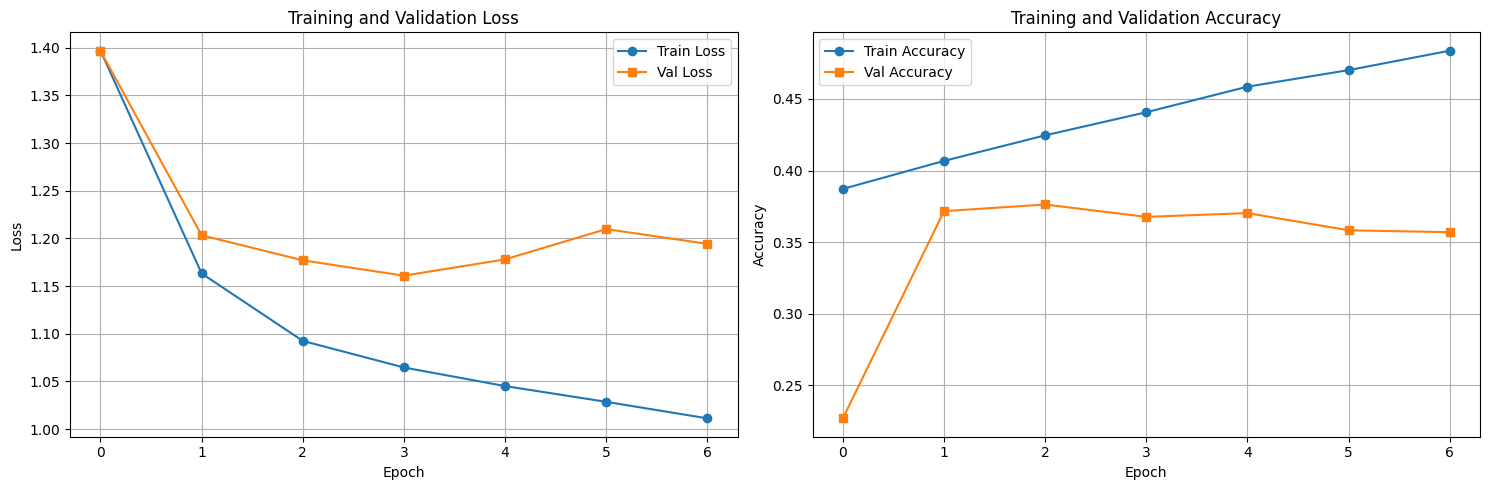

In [ ]:
# # Final evaluation
print("\nFinal evaluation on validation set:")
val_predictions, val_true_labels, _, _, _, final_accuracy = evaluate(
    model, val_loader, device, criterion
)

print(f"Final Validation Accuracy: {final_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(
    val_true_labels,
    val_predictions,
    target_names=['Negative', 'Neutral', 'Positive'],
    digits=4
))

# Plot results
plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies)
# plot_confusion_matrix(val_true_labels, val_predictions)

# Best F1-weighted score achieved after running the code multiple times = 37.82